In [9]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
import warnings 

# --- Core analysis functions (No changes needed here from last version) ---
def pendulum_velocity(x, k, r, phi):
    arg = 2 * k * (r - np.cos(x - phi))
    return np.sqrt(np.maximum(0, arg))

def bin_and_fit(angle_forv, angle_v, angle_bins):
    median_velocity, pct_95_velocity, std_err_median = [], [], []
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2
    bin_width = angle_bins[1] - angle_bins[0]
    binned_data_for_plot = []

    for i in range(len(bin_centers)):
        mask = (angle_forv >= angle_bins[i]) & (angle_forv < angle_bins[i + 1])
        if np.any(mask):
            vals = angle_v[mask]
            # Check if vals is empty after potential NaN filtering inside the mask
            # Also filter potential NaNs within vals itself if they exist
            vals_finite = vals[np.isfinite(vals)]
            if len(vals_finite) > 0:
                median_velocity.append(np.median(vals_finite))
                pct_95_velocity.append(np.percentile(vals_finite, 95))
                # Std Error of Median approximation (using IQR for robustness)
                q75, q25 = np.percentile(vals_finite, [75 ,25])
                iqr = q75 - q25
                std_approx = iqr / 1.349 # Robust standard deviation estimate
                std_err_median.append(1.253 * std_approx / np.sqrt(len(vals_finite)) if len(vals_finite) > 1 else 0) 
                binned_data_for_plot.append(vals_finite) # Append finite vals for boxplot
            else:
                median_velocity.append(np.nan)
                pct_95_velocity.append(np.nan)
                std_err_median.append(np.nan)
                binned_data_for_plot.append(np.array([]))
        else:
            median_velocity.append(np.nan)
            pct_95_velocity.append(np.nan)
            std_err_median.append(np.nan)
            binned_data_for_plot.append(np.array([]))

    popt = _fit_popt(bin_centers, np.array(median_velocity))

    return (
        np.array(median_velocity),
        np.array(pct_95_velocity),
        np.array(std_err_median),
        popt,
        bin_centers,
        bin_width,
        binned_data_for_plot
    )


def _fit_popt(bin_centers, median_velocity):
    valid = ~np.isnan(median_velocity) & (median_velocity > 1e-9) # Ensure median > tiny value for sqrt fit

    if np.sum(valid) < 3:
         print("Warning: Not enough valid data points (<3) to perform fit. Returning default parameters.")
         return [0.1, 1, 0]

    try:
        # Improved initial guess for phi: angle where median velocity is max
        phi_guess = bin_centers[valid][np.argmax(median_velocity[valid])] if np.any(valid) else 0
        p0_guess = [np.nanmax(median_velocity**2)/4 if np.any(valid) else 0.1, # Rough guess for k*r based on max speed^2/4
                    1, 
                    phi_guess] 
        # Ensure p0 is finite and within bounds
        p0_guess = [max(1e-9, p) for p in p0_guess[:2]] + [p0_guess[2]] # Ensure k,r > 0
        p0_guess[2] = p0_guess[2] % (2*np.pi) # Map phi to [0, 2pi)

        popt, pcov = curve_fit(
            pendulum_velocity,
            bin_centers[valid],
            median_velocity[valid], # Fit directly median (should be positive)
            p0=p0_guess,
            bounds=([0, 0, -np.pi], [np.inf, np.inf, 3*np.pi]), # Allow phi slightly outside [0, 2pi] during fit
            maxfev=8000
        )
        # Map final phi back to [0, 2pi) for consistency
        popt[2] = popt[2] % (2 * np.pi) 

        # Basic check on fit quality (optional)
        residuals = median_velocity[valid] - pendulum_velocity(bin_centers[valid], *popt)
        # Check relative error
        rel_error = np.sum(residuals**2) / np.sum(median_velocity[valid]**2) if np.sum(median_velocity[valid]**2) > 1e-9 else float('inf')
        if rel_error > 0.5: # If relative error is huge (e.g., > 50%)
             print(f"Warning: Fit has high relative error ({rel_error:.2f}). Check data/fit. Params: {popt}")

    except (RuntimeError, ValueError) as e:
        print(f"Warning: Curve fit failed with error: {e}. Returning default parameters.")
        popt = [0.1, 1, 0]
    except Exception as e:
         print(f"Warning: An unexpected error occurred during fitting: {e}. Returning default parameters.")
         popt = [0.1, 1, 0]

    if popt[0] < 1e-9 or popt[1] < 1e-9: # Check if k or r effectively zero
         print(f"Warning: Fit resulted in near-zero k or r: k={popt[0]:.2e}, r={popt[1]:.2e}. Check data/units. Returning default.")
         popt = [0.1, 1, 0] # Return default if params non-physical

    return popt


def calculate_angles(frames, x1, y1, x2, y2, center1, center2):
    angles1, angles2 = [], []
    for xi1, yi1, xi2, yi2 in zip(x1, y1, x2, y2):
        angles1.append(np.arctan2(yi1 - center1[1], xi1 - center1[0]))
        angles2.append(np.arctan2(yi2 - center2[1], xi2 - center2[0]))
    return np.array(angles1), np.array(angles2)


def calculate_velocities(frames, angles1, angles2):
    phi1_sub = angles1[::6]
    phi2_sub = angles2[::6]
    t = np.array(frames[::6])

    if len(t) < 2:
        print("Warning: Not enough data points after subsampling to calculate velocity.")
        return np.array([]), np.array([]), np.array([]), np.array([])

    phi1_unwrapped = np.unwrap(phi1_sub)
    phi2_unwrapped = np.unwrap(phi2_sub)

    dt = np.diff(t)
    if np.any(dt <= 1e-9): # Check for zero or near-zero dt more robustly
        print("Warning: Zero or near-zero time difference detected. Check frame data / subsampling rate.")
        dt[dt <= 1e-9] = np.nan 

    v1_raw = np.diff(phi1_unwrapped) / dt
    v2_raw = np.diff(phi2_unwrapped) / dt

    ph1_for_v = phi1_sub[:-1]
    ph2_for_v = phi2_sub[:-1]

    v1_abs = np.abs(v1_raw)
    v2_abs = np.abs(v2_raw)

    def filt(data):
        finite_data = data[np.isfinite(data)]
        if len(finite_data) < 4:
             return data
        q1, q3 = np.percentile(finite_data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return np.where((data < lower_bound) | (data > upper_bound), np.nan, data)

    v1_filt = filt(v1_abs)
    v2_filt = filt(v2_abs)

    mask1 = ~np.isnan(v1_filt)
    mask2 = ~np.isnan(v2_filt)

    return v1_filt[mask1], v2_filt[mask2], ph1_for_v[mask1], ph2_for_v[mask2]


# --- Plotting Function (Modified for Precision in Labels) ---
def plot_combined(frames, angles1, angles2, v1, v2, ph1, ph2,
                  bin_results1, bin_results2):

    med1, p95_1, _, popt1, cent1, bw1, binned_data1 = bin_results1
    med2, p95_2, _, popt2, cent2, bw2, binned_data2 = bin_results2

    xfit = np.linspace(0, 2 * np.pi, 500)
    yfit1 = pendulum_velocity(xfit, *popt1)
    yfit2 = pendulum_velocity(xfit, *popt2)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # --- Object 1 Phase Plot ---
        axs[0].scatter(ph1, v1, alpha=0.1, color='green', label='Raw Data (abs speed)', s=5)
        valid_binned_data1 = [d for d in binned_data1 if len(d) > 0]
        valid_cent1 = cent1[[len(d) > 0 for d in binned_data1]]
        if len(valid_binned_data1) > 0:
             axs[0].boxplot(valid_binned_data1, positions=valid_cent1, widths=bw1 * 0.4, patch_artist=True,
                           showfliers=False, boxprops=dict(facecolor='lightgreen', alpha=0.7),
                           medianprops=dict(color='red', linewidth=1.5))
        valid_med1 = ~np.isnan(med1)
        axs[0].plot(cent1[valid_med1], med1[valid_med1], 'ro-', markersize=4, label='Median')
        valid_p95_1 = ~np.isnan(p95_1)
        axs[0].plot(cent1[valid_p95_1], p95_1[valid_p95_1], 'mo--', markersize=4, label='95th pct')
        
        # *** Use scientific notation for k, adjusted precision for others in label ***
        fit_label1 = (f'Fit (k={popt1[0]:.3e}, r={popt1[1]:.3f}, '
                      f'$\\phi$={popt1[2]:.3f})')
        axs[0].plot(xfit, yfit1, 'b-', linewidth=2, label=fit_label1)
        
        axs[0].set_xticks(np.linspace(0, 2*np.pi, 9))
        axs[0].set_xticklabels([f"{c:.2f}" for c in np.linspace(0, 2*np.pi, 9)], rotation=45)
        axs[0].set_xlabel("Angle (rad, $0$ to $2\pi$)") # Use LaTeX for pi
        axs[0].set_ylabel("Angular Speed (rad/s)")
        axs[0].set_title('Object 1: Speed vs Angle')
        axs[0].legend(); axs[0].grid(True)
        axs[0].set_ylim(bottom=0)
        axs[0].set_xlim(0, 2 * np.pi)

        # --- Object 2 Phase Plot ---
        axs[1].scatter(ph2, v2, alpha=0.1, color='blue', label='Raw Data (abs speed)', s=5)
        valid_binned_data2 = [d for d in binned_data2 if len(d) > 0]
        valid_cent2 = cent2[[len(d) > 0 for d in binned_data2]]
        if len(valid_binned_data2) > 0:
            axs[1].boxplot(valid_binned_data2, positions=valid_cent2, widths=bw2 * 0.4, patch_artist=True,
                           showfliers=False, boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='red', linewidth=1.5))
        valid_med2 = ~np.isnan(med2)
        axs[1].plot(cent2[valid_med2], med2[valid_med2], 'ro-', markersize=4, label='Median')
        valid_p95_2 = ~np.isnan(p95_2)
        axs[1].plot(cent2[valid_p95_2], p95_2[valid_p95_2], 'mo--', markersize=4, label='95th pct')

        # *** Use scientific notation for k, adjusted precision for others in label ***
        fit_label2 = (f'Fit (k={popt2[0]:.3e}, r={popt2[1]:.3f}, '
                      f'$\\phi$={popt2[2]:.3f})')
        axs[1].plot(xfit, yfit2, 'b-', linewidth=2, label=fit_label2)

        axs[1].set_xticks(np.linspace(0, 2*np.pi, 9))
        axs[1].set_xticklabels([f"{c:.2f}" for c in np.linspace(0, 2*np.pi, 9)], rotation=45)
        axs[1].set_xlabel("Angle (rad, $0$ to $2\pi$)") # Use LaTeX for pi
        axs[1].set_ylabel("Angular Speed (rad/s)")
        axs[1].set_title('Object 2: Speed vs Angle')
        axs[1].legend(); axs[1].grid(True)
        axs[1].set_ylim(bottom=0)
        axs[1].set_xlim(0, 2 * np.pi)

    # --- Angle vs Time ---
    axs[2].plot(frames, angles1, label='Obj1 Angle', alpha=0.7)
    axs[2].plot(frames, angles2, label='Obj2 Angle', alpha=0.7)
    axs[2].set_title('Angle vs Time')
    axs[2].set_xlabel("Frame Number")
    axs[2].set_ylabel("Angle (rad, $-\pi$ to $\pi$)") # Use LaTeX for pi
    axs[2].legend(); axs[2].grid(True)

    # --- Overall Distribution ---
    v1_finite = v1[np.isfinite(v1)]
    v2_finite = v2[np.isfinite(v2)]

    if len(v1_finite)>0 or len(v2_finite)>0:
         data_to_plot = []
         labels = []
         colors = []
         medians = []
         if len(v1_finite)>0:
              data_to_plot.append(v1_finite)
              labels.append('Obj1')
              colors.append('lightgreen')
              medians.append(np.median(v1_finite))
         if len(v2_finite)>0:
              data_to_plot.append(v2_finite)
              labels.append('Obj2')
              colors.append('lightblue')
              medians.append(np.median(v2_finite))

         bp = axs[3].boxplot(data_to_plot, labels=labels, patch_artist=True, showfliers=False)
         for patch, color in zip(bp['boxes'], colors):
             patch.set_facecolor(color)
         # Plot medians if they exist
         if medians:
            axs[3].plot(range(1, len(medians) + 1), medians, 'ro', label='Median Speed')
         axs[3].set_title('Overall Speed Distribution')
         axs[3].set_ylabel("Angular Speed (rad/s)")
         axs[3].legend(); axs[3].grid(True)
         axs[3].set_ylim(bottom=0)
    else:
         axs[3].set_title('Overall Speed Distribution (No data)')

    # --- FFT Analysis with Harmonics Marking ---
    time_data = np.array(frames)    # Frame numbers or timestamps
    T = np.mean(np.diff(time_data)) # Sampling interval
    N = len(time_data)              # Number of samples

    fig_f, (ax_f1, ax_f2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    for angle_data, ax, label in [
        (angles1, ax_f1, 'Pendulum 1'),
        (angles2, ax_f2, 'Pendulum 2')
    ]:
        # Remove DC and compute FFT
        y = angle_data - np.mean(angle_data)
        Y = fft(y)
        freqs = fftfreq(N, T)[:N//2]
        amps  = 2.0 / N * np.abs(Y[:N//2])

        # Find fundamental: the frequency with maximum amplitude (excluding zero)
        pos = freqs > 0
        if np.any(pos):
            f_pos = freqs[pos]
            a_pos = amps[pos]
            peak_idx = np.argmax(a_pos)
            f0 = f_pos[peak_idx]
        else:
            f0 = 0.0

        # Plot the full positive‐frequency spectrum
        ax.plot(freqs, amps, lw=1.5)
        ax.set_title(f'Frequency Spectrum — {label}')
        ax.set_ylabel('Amplitude')
        ax.set_xlim(0,0.001)
        ax.grid(True)

        # Overlay harmonics of f0 up to Nyquist
        if f0 > 0:
            max_h = int(freqs[-1] // f0)
            for n in range(1, max_h + 1):
                ax.axvline(n * f0,
                           color='red',
                           linestyle='--',
                           linewidth=1)
            # Annotate the fundamental
            ax.text(f0, amps.max() * 0.9,
                    f'{f0:.2e} Hz',
                    color='red',
                    ha='center',
                    va='bottom')

    ax_f2.set_xlabel('Frequency (Hz)')


    plt.tight_layout()
    # Don't call plt.show() here if you want process_folder to control display
    return fig


# --- Main Processing Function (Modified for Precision and Plot Display) ---
def process_folder(folder):
    coords_path = os.path.join(folder, 'coordinates.csv')
    meta_file = os.path.join(folder, 'metadata.json')

    if not os.path.exists(coords_path) or not os.path.exists(meta_file):
        raise FileNotFoundError(f'Expect {coords_path} and {meta_file}')

    df = pd.read_csv(coords_path)
    if df.shape[1] < 5:
         raise ValueError(f"Expected >= 5 columns in {coords_path}, found {df.shape[1]}")

    frames = df.iloc[:, 0].values
    x1, y1, x2, y2 = [df.iloc[:, i].values for i in range(1, 5)]

    with open(meta_file) as j:
        m = json.load(j)
    if 'obj1_pivot' not in m or 'obj2_pivot' not in m:
        raise KeyError("Metadata missing 'obj1_pivot' or 'obj2_pivot'")
    c1, c2 = m['obj1_pivot'], m['obj2_pivot']

    angles1_raw, angles2_raw = calculate_angles(frames, x1, y1, x2, y2, c1, c2)
    v1, v2, ph1_for_v, ph2_for_v = calculate_velocities(frames, angles1_raw, angles2_raw)

    # Check if velocity calculation returned data
    if len(v1)==0 and len(v2)==0:
         print("No valid velocity data found. Skipping fitting and plotting.")
         return # Exit early

    ph1_mapped = ph1_for_v % (2 * np.pi)
    ph2_mapped = ph2_for_v % (2 * np.pi)

    bins = np.linspace(0, 2 * np.pi, 17)

    bin_results1 = bin_and_fit(ph1_mapped, v1, bins)
    bin_results2 = bin_and_fit(ph2_mapped, v2, bins)

    popt1 = bin_results1[3]
    popt2 = bin_results2[3]
    k1, r1, phi1 = popt1
    k2, r2, phi2 = popt2

    L1 = np.nanmean(np.hypot(x1 - c1[0], y1 - c1[1]))
    L2 = np.nanmean(np.hypot(x2 - c2[0], y2 - c2[1]))

    g1 = k1 * L1 if L1 > 1e-9 else np.nan # Avoid division by zero if L is tiny
    g2 = k2 * L2 if L2 > 1e-9 else np.nan

    # *** Print results using scientific notation for potentially small values ***
    print(f"\n--- Analysis Results for Folder: {folder} ---")
    print(f"Object 1: L_mean={L1:.6f}, k_fit={k1:.6e}, r_fit={r1:.6f}, phi_fit={phi1:.6f} -> g_estimate = {g1:.6e}")
    print(f"Object 2: L_mean={L2:.6f}, k_fit={k2:.6e}, r_fit={r2:.6f}, phi_fit={phi2:.6f} -> g_estimate = {g2:.6e}")
    print("----------------------------------------------")

    # *** Save results using scientific notation for potentially small values ***
    out = {
           # Use .6e for values that might be very small or large
           'g_object1': f"{g1:.6e}" if np.isfinite(g1) else "NaN",
           'g_object2': f"{g2:.6e}" if np.isfinite(g2) else "NaN",
           'k1_fit': f"{k1:.6e}" if np.isfinite(k1) else "NaN",
           'k2_fit': f"{k2:.6e}" if np.isfinite(k2) else "NaN",
           # Use .6f for values likely in a 'normal' range, like length, r, phi
           'L1_mean': f"{L1:.6f}" if np.isfinite(L1) else "NaN",
           'L2_mean': f"{L2:.6f}" if np.isfinite(L2) else "NaN",
           'r1_fit': f"{r1:.6f}" if np.isfinite(r1) else "NaN",
           'r2_fit': f"{r2:.6f}" if np.isfinite(r2) else "NaN",
           'phi1_fit': f"{phi1:.6f}" if np.isfinite(phi1) else "NaN",
           'phi2_fit': f"{phi2:.6f}" if np.isfinite(phi2) else "NaN"
           }
    jpath = os.path.join(folder, 'analysis_results.json')
    with open(jpath, 'w') as f:
        json.dump(out, f, indent=2)
    print(f"Saved analysis results to {jpath}")

    # --- Plotting ---
    fig = plot_combined(frames, angles1_raw, angles2_raw,
                        v1, v2, ph1_mapped, ph2_mapped,
                        bin_results1, bin_results2)

    combined_path = os.path.join(folder, 'combined_analysis_plots.jpeg')
    try:
        fig.savefig(combined_path, dpi=300, bbox_inches='tight')
        print(f"Saved combined plots to {combined_path}")
        # *** Show the plot after saving ***
        plt.show()
    except Exception as e:
        print(f"Error saving or showing plot: {e}")
    finally:
        # *** Close the figure after showing/saving ***
        plt.close(fig)


--- Analysis Results for Folder: C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024-09-18\mega ---
Object 1: L_mean=303.933286, k_fit=3.140162e-08, r_fit=3.736451, phi_fit=6.175199 -> g_estimate = 9.543999e-06
Object 2: L_mean=290.917600, k_fit=1.706576e-08, r_fit=4.599761, phi_fit=5.217516 -> g_estimate = 4.964729e-06
----------------------------------------------
Saved analysis results to C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024-09-18\mega\analysis_results.json
Saved combined plots to C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024-09-18\mega\combined_analysis_plots.jpeg


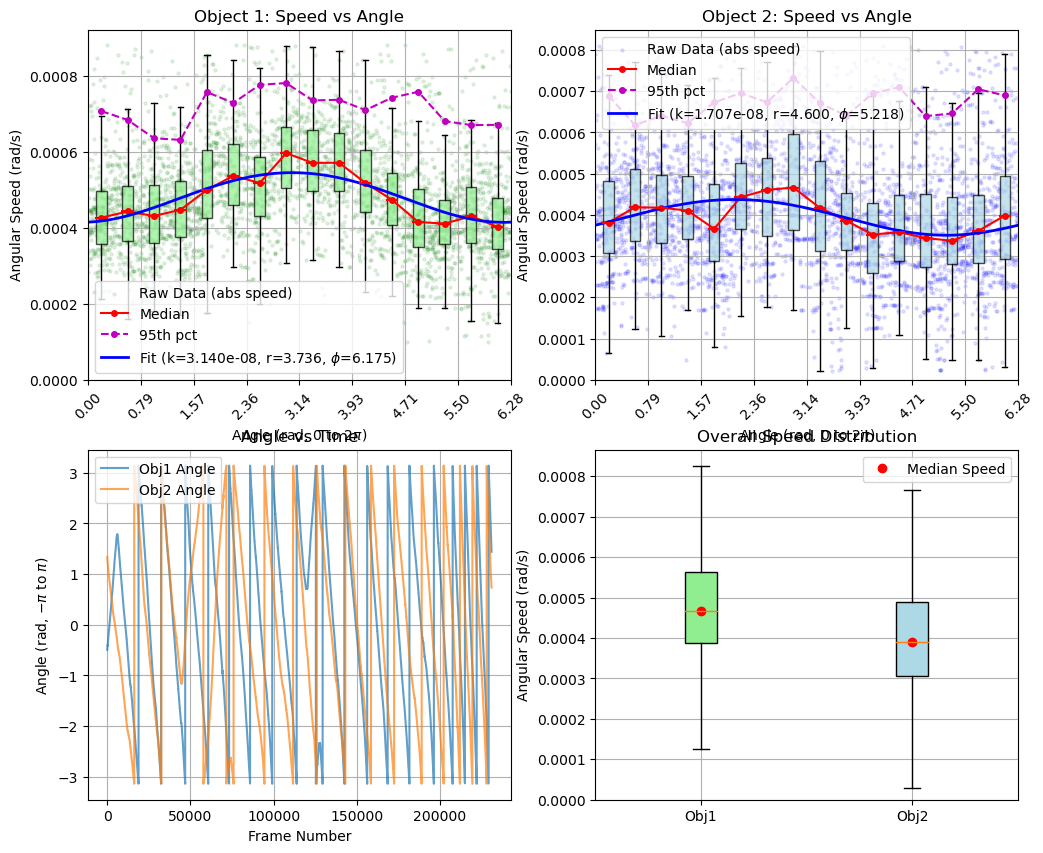

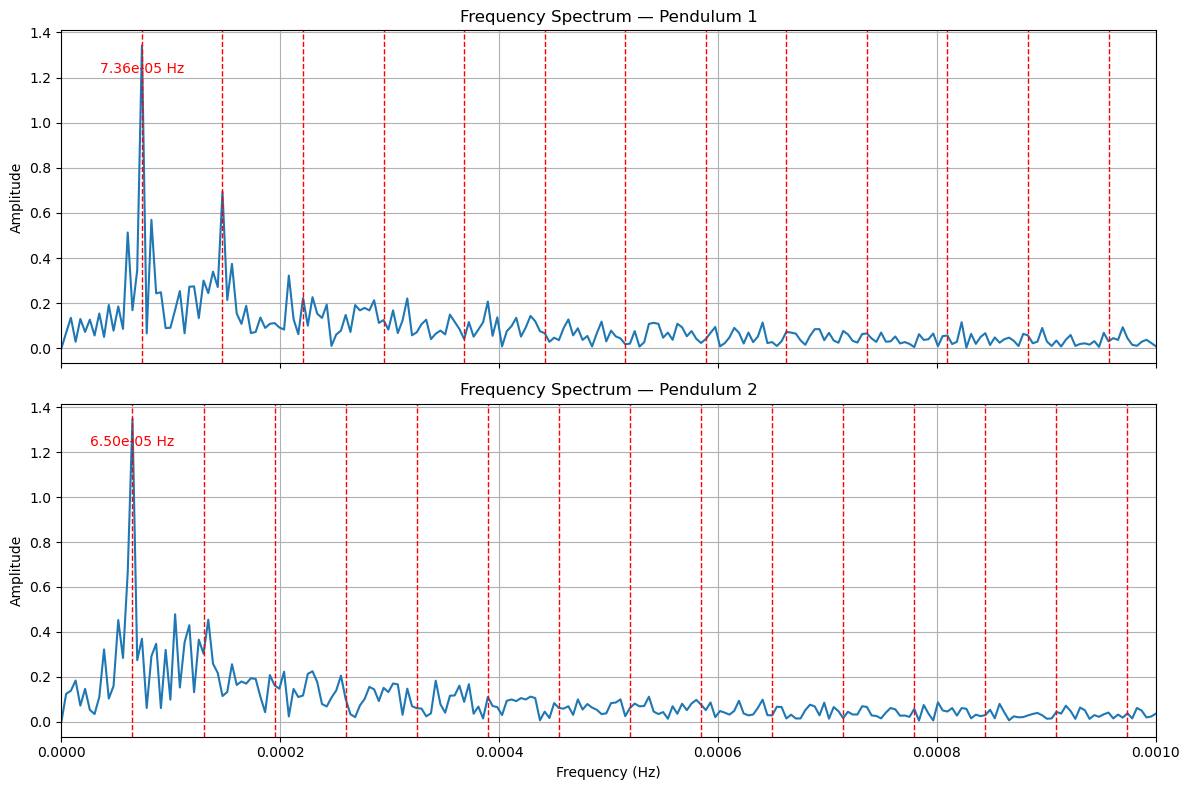

In [10]:
process_folder(R"C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024-09-18\mega")

## Acceleration vs Distance Between Pendulums

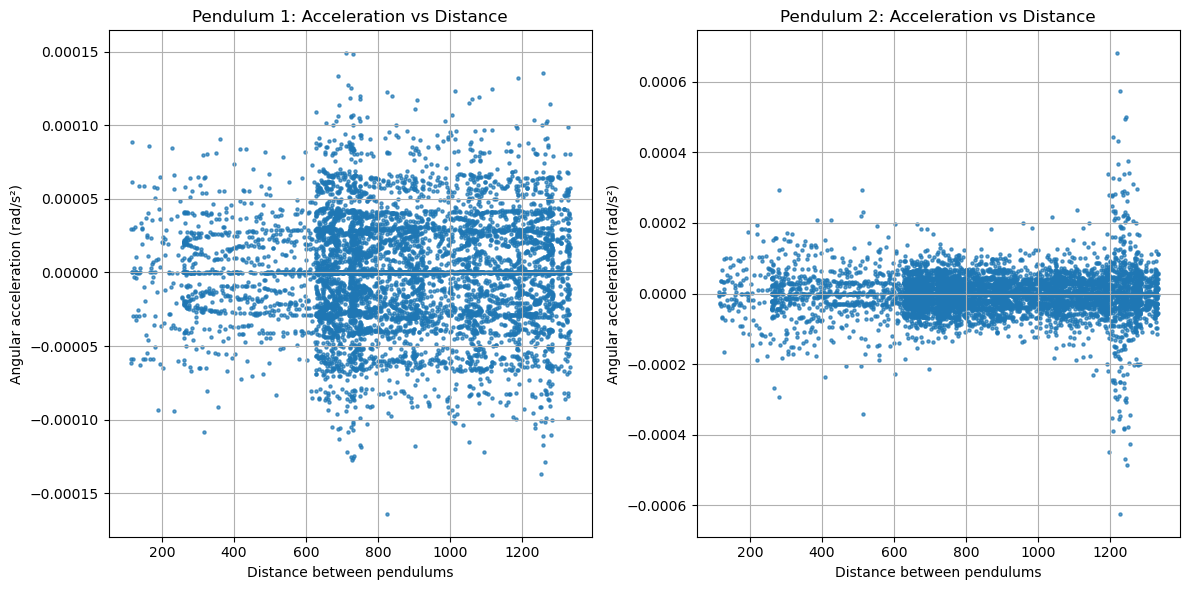

In [12]:
#!/usr/bin/env python3
"""
Jupyter-friendly module to plot angular acceleration vs distance between two coupled pendulums.

Define the function below and call it directly in a notebook cell:

    plot_acc_vs_distance('/path/to/data_folder')

This will display two side-by-side scatter plots:
  - Pendulum 1: acceleration vs distance
  - Pendulum 2: acceleration vs distance
"""
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_acc_vs_distance(folder):
    # Load CSV of frames and positions
    coords_path = os.path.join(folder, 'coordinates.csv')
    meta_path   = os.path.join(folder, 'metadata.json')

    df = pd.read_csv(coords_path)
    with open(meta_path, 'r') as f:
        meta = json.load(f)
    c1 = tuple(meta['obj1_pivot'])
    c2 = tuple(meta['obj2_pivot'])

    # Extract time and positions
    t  = df.iloc[:, 0].values
    x1 = df.iloc[:, 1].values; y1 = df.iloc[:, 2].values
    x2 = df.iloc[:, 3].values; y2 = df.iloc[:, 4].values

    # Compute unwrapped angles
    ang1 = np.unwrap(np.arctan2(y1 - c1[1], x1 - c1[0]))
    ang2 = np.unwrap(np.arctan2(y2 - c2[1], x2 - c2[0]))

    # Compute angular velocities
    dt = np.diff(t)
    omega1 = np.diff(ang1) / dt
    omega2 = np.diff(ang2) / dt

    # Compute angular accelerations
    alpha1 = np.diff(omega1) / dt[1:]
    alpha2 = np.diff(omega2) / dt[1:]

    # Instantaneous distance between pendulums (aligned with alpha arrays)
    dist = np.hypot(x1 - x2, y1 - y2)
    dist_mid = dist[2:]

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].scatter(dist_mid, alpha1, s=5, alpha=0.7)
    axs[0].set_title('Pendulum 1: Acceleration vs Distance')
    axs[0].set_xlabel('Distance between pendulums')
    axs[0].set_ylabel('Angular acceleration (rad/s²)')
    axs[0].grid(True)

    axs[1].scatter(dist_mid, alpha2, s=5, alpha=0.7)
    axs[1].set_title('Pendulum 2: Acceleration vs Distance')
    axs[1].set_xlabel('Distance between pendulums')
    axs[1].set_ylabel('Angular acceleration (rad/s²)')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_acc_vs_distance(R"C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024-09-18\S6130001")
